# Final Project "Predict Future Sales"

"How to win a data science competition" Coursera course

by Elena Fominskaya

Dec. 2018

## Content

#### 1. Data Loading
#### Useful functions
#### 2. Feature preprocessing
    2.1. Parse dates and generate date-features
        Simple time-based features and simple non_tree models treated them:
    2.2. Features "sale cnt in mounth N for the particular shop_item"
    2.3. Moving Average¶
        Cross-Validation on a Rolling Basis
    2.4. Exponential smoothing¶
        Cross-Validation on a Rolling Basis
#### 3. Feature extraction
    Feature extraction from text¶
    3.1. Add meta_category based on category name
    3.2. Add city to the shops based on shop name
#### 4. EDA and Data Leakages
    4.1. Exam transactions
    4.2. Exam shops and their histories
    4.3. EDA and Data Leakage insights:¶
    4.4. Cleaning Data after EDA and Data Leakage
#### 5. Advanced Features
    5.1 Mean Encodings
        Create a grid shops-items-month
        Add mean encoding features 
    5.2. Additional advanced features
#### 6. Prepair train and valid data sets for simple Light GBM  and Linear Model 
#### 7. Simple LightGBM
    Train and predict for test
    Look for importance features
#### 8. Simple Linear Regression
    Train and predict for test
    Look for importance features
#### 9. Cross Validation
    9.1. CV for LightGBM
    9.1. CV for Linear model
#### 10. Metrics optimization and Hyperparameter tuning
    10.1. CV_grid_optimization for LightGBM
    10.2. CV_grid_optimization for Linear Model
#### 11.Ensemble



Used libs vers:
- numpy 1.14.2
- pandas 0.22.0
- scipy 1.0.1
- sklearn 0.19.1
- lightgbm 2.0.6

In [5]:
import pandas as pd
import numpy as np
import os
import time
import math
import gc
import pickle

import matplotlib.pyplot as plt
%matplotlib inline 

from tqdm import tqdm_notebook
from itertools import product

import sklearn
from sklearn import linear_model
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import TimeSeriesSplit

from scipy.optimize import minimize
import scipy

import lightgbm as lgb

import seaborn as sns

## Libs Vers 

In [6]:
for p in [np, pd, scipy, sklearn, lgb]:
    print (p.__name__, p.__version__)

numpy 1.14.2
pandas 0.22.0
scipy 1.0.1
sklearn 0.19.1
lightgbm 2.0.6


## Fix Env 

In [7]:
np.random.seed(2)

### Structure:

input_data/ - provided data

work_data/ - datasets for models and serialized trained models

models/ - train models

# 1. Data Loading

In [8]:
DATA_FOLDER = 'input_data/'

transactions    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))

test            = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))
sample_sub      = pd.read_csv(os.path.join(DATA_FOLDER, 'sample_submission.csv'))

In [9]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [10]:
items.describe()

,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


In [11]:
item_categories.head(10)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [12]:
item_categories.describe()

,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000


84 different categories (starting at 0 with "PC")

Each category has a name

some meta-categories - add meta !

In [13]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [14]:
shops.describe()

,shop_id
count,60.000000
mean,29.500000
std,17.464249
min,0.000000
25%,14.750000
50%,29.500000
75%,44.250000
max,59.000000


60 shops 

Each shop has a name

some meta - city name - add city!

In [15]:
transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [16]:
transactions.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


2 935 849 items in train-set

transaction history of 60 shops for 34 months

no NaNs in the data

In [17]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [18]:
test.describe()

,ID,shop_id,item_id
count,214200.000000,214200.000000,214200.000000
mean,107099.500000,31.642857,11019.398627
std,61834.358168,17.561933,6252.644590
min,0.000000,2.000000,30.000000
25%,53549.750000,16.000000,5381.500000
50%,107099.500000,34.500000,11203.000000
75%,160649.250000,47.000000,16071.500000
max,214199.000000,59.000000,22167.000000


214 200 items in test

need to make predictions for shops 2-59 (no 0 and 1) for certain items sold per month

not all item_ids in each shop: 60  * 22 167 = 1 330 000 

# Useful functions

In [19]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe:               
                `float64` type to `float32`
                `int64`   type to `int32`
    '''    
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"] 
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)   
    
    return df

In [20]:
'''
    Parse and formate DATEs
'''    
    
def parse_date(df):
    _df = df.copy()
    _df["date"] = pd.to_datetime(_df.date, format="%d.%m.%Y")
    return _df

def day_month_year(df):
    _df = df.copy()
    _df["day"] = _df.date.apply(lambda x: x.day)
    _df["month"] = _df.date.apply(lambda x: x.month)
    _df["year"] = _df.date.apply(lambda x: x.year)
    return _df

# Transformers
parse_date_transformer = FunctionTransformer(parse_date, validate=False)
day_month_year_transformer = FunctionTransformer(day_month_year, validate=False)

# Pipelines
date_pipeline = make_pipeline(parse_date_transformer, day_month_year_transformer)

# Main Pipeline
preprocessing_pipeline = make_pipeline(date_pipeline)

In [21]:
def train_valid_split(dataset, last_block, to_drop_cols):
    '''
        Split dataset into sets for train and validation:  
        
        dataset - dateset to be splitted
        last_block - number of the month to validate on
        to_drop_cols - list of columns of dataset to drop from train and validation

        Return
        X_train, X_valid, y_train, y_valid
    '''    
    X_train = dataset.loc[dates <  last_block].drop(to_drop_cols, axis=1)
    X_valid =  dataset.loc[dates == last_block].drop(to_drop_cols, axis=1)

    y_train = dataset.loc[dates <  last_block, 'cnt_month'].values
    y_valid =  dataset.loc[dates == last_block, 'cnt_month'].values
    
    return  X_train, X_valid,  y_train, y_valid

# Useful datasets

In [22]:
# pairs shop-item from transactions
shop_item_df = transactions[['shop_id','item_id']]
shop_item_df = shop_item_df.drop_duplicates()

# 2. Feature preprocessing

## 2.1. Parse dates and generate date-features 

In [23]:
transactions = preprocessing_pipeline.transform(transactions)

In [24]:
transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
0,2013-01-02,0,59,22154,999.00,1.0,2,1,2013
1,2013-01-03,0,25,2552,899.00,1.0,3,1,2013
2,2013-01-05,0,25,2552,899.00,-1.0,5,1,2013
3,2013-01-06,0,25,2554,1709.05,1.0,6,1,2013
4,2013-01-15,0,25,2555,1099.00,1.0,15,1,2013


## Simple time-based features and simple non_tree models treated them:
## 2.2. Features "sale cnt in mounth N for the particular shop_item" 

In [25]:
# transactions_months - data set grouped by every month with sum of cnt for every pair shop-item
# feature "cnt_monthN" is the sale cnt in mounth N for the particular shop_item

for month in range (34):
    ind_month = (transactions.date_block_num == month)
    
    df = transactions[ind_month].groupby(["shop_id", "item_id"], as_index=False).item_cnt_day.sum().rename(
        columns={"item_cnt_day": "cnt_month_"+str(month)})
    
    shop_item_df = pd.merge(shop_item_df, df , how='left', on=['shop_id','item_id']).fillna(0)
    
transactions_months = shop_item_df.copy()

transactions_months = pd.merge(test, transactions_months, how='left', on=['shop_id','item_id']).fillna(0)
del df

In [26]:
transactions_months.head()

,ID,shop_id,item_id,cnt_month_0,cnt_month_1,cnt_month_2,cnt_month_3,cnt_month_4,cnt_month_5,cnt_month_6,...,cnt_month_24,cnt_month_25,cnt_month_26,cnt_month_27,cnt_month_28,cnt_month_29,cnt_month_30,cnt_month_31,cnt_month_32,cnt_month_33
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
with open('work_data/transactions_months.pickle', 'wb') as f:
    pickle.dump(transactions_months, f)

## 2.3. Moving Average 
### Cross-Validation on a Rolling Basis 
Assume that the future value of the variable depends on the average n of its previous values.

In [28]:
def moving_average(series, n):
    return np.average(series[-n:])

In [29]:
y_for_mov_average = transactions_months['cnt_month_33']

errors = []
for n in range(31):
    p_pred = transactions_months.iloc[:,-n-2:-1].mean(axis=1)
    error = mean_squared_error(p_pred, y_for_mov_average)
    errors.append(error)

best_ind_cv = np.argmin(errors)
print("The best mean_squared_error for Cross-Validation of Moving Average: ", min(errors))
print("The best month ind in Cross-Validation of Moving Average: ", best_ind_cv)

The best mean_squared_error for Cross-Validation of Moving Average:  21.316275443510733
The best month ind in Cross-Validation of Moving Average:  4


In [30]:
pred_mov_average = transactions_months.iloc[:,-best_ind_cv+2:].mean(axis=1)

In [31]:
y_pred_df = transactions_months[['shop_id','item_id']].copy()
y_pred_df['item_cnt_month']=pred_mov_average

test_data_mov_average = pd.merge(test,
                                  y_pred_df,
                                  how='left', 
                                  on=['shop_id','item_id']).fillna(0)

test_data_mov_average.item_cnt_month = np.clip(test_data_mov_average['item_cnt_month'], 0, 20)
test_data_mov_average[['ID','item_cnt_month']].to_csv('sub_moving_average23.csv', index=False)

## 2.4. Exponential smoothing
### Cross-Validation on a Rolling Basis
Here the model value is a weighted average between the current true value and the previous model values. The α a smoothing factor defines how quickly we will “forget” the last available true observation.
Multiply each time (1−α) by the previous model value which, in its turn, also containes (1−α) and so forth until the very beginning.

In [32]:
def exponential_smoothing(series):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
        
    return result

In [33]:
# Tuning of ALPHA
df = transactions_months.iloc[:, 3:-1]
y_exp_smooth = transactions_months.iloc[:, -1]

alphas = np.linspace(0.01, 0.99, num=10)
errors = []

for alpha in alphas:
    pred_exp_smooth = df.apply(exponential_smoothing, axis=1)
    err = mean_squared_error(y_exp_smooth.values, pred_exp_smooth.iloc[:,-1].values)
    errors.append(err)
    
best_alpha_exp_smooth = alphas[np.array(errors).argmin()]    
print("The best mean_squared_error for Cross-Validation of Exponential smoothing: ", min(errors))
print("The best alpha in Cross-Validation of Exponential smoothing: ", best_alpha_exp_smooth)

The best mean_squared_error for Cross-Validation of Exponential smoothing:  22.161297056289694
The best alpha in Cross-Validation of Exponential smoothing:  0.22777777777777777


In [34]:
pred_exp_smooth = transactions_months.iloc[:, 3:].apply(exponential_smoothing, axis=1).iloc[:,-1].values

In [35]:
y_pred_df = transactions_months[['shop_id','item_id']].copy()
y_pred_df['item_cnt_month']=pred_exp_smooth

test_data_exp_smooth = pd.merge(test,
                                  y_pred_df,
                                  how='left', 
                                  on=['shop_id','item_id']).fillna(0)

test_data_exp_smooth.item_cnt_month = np.clip(test_data_exp_smooth['item_cnt_month'], 0, 20)

test_data_exp_smooth[['ID','item_cnt_month']].to_csv('sub_exp_smooth23.csv', index=False)

# 3. Feature extraction

## Feature extraction from text

## 3.1. Add meta_category based on category name 

In [36]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [37]:
item_categories["meta_category"]=item_categories.item_category_name.apply(lambda x:x.split(" - ")[0])

In [38]:
item_categories.head(12)

,item_category_name,item_category_id,meta_category
0,PC - Гарнитуры/Наушники,0,PC
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары
5,Аксессуары - PSVita,5,Аксессуары
6,Аксессуары - XBOX 360,6,Аксессуары
7,Аксессуары - XBOX ONE,7,Аксессуары
8,Билеты (Цифра),8,Билеты (Цифра)
9,Доставка товара,9,Доставка товара


In [39]:
item_categories.meta_category.unique()

array(['PC', 'Аксессуары', 'Билеты (Цифра)', 'Доставка товара',
       'Игровые консоли', 'Игры', 'Игры Android', 'Игры MAC', 'Игры PC',
       'Карты оплаты (Кино, Музыка, Игры)', 'Карты оплаты', 'Кино',
       'Книги', 'Музыка', 'Подарки', 'Программы', 'Служебные',
       'Чистые носители (шпиль)', 'Чистые носители (штучные)',
       'Элементы питания'], dtype=object)

In [40]:
item_categories.meta_category.nunique()

20

In [41]:
item_categories.meta_category.value_counts()

Книги                                13
Подарки                              12
Игровые консоли                       8
Игры                                  8
Аксессуары                            7
Программы                             6
Музыка                                6
Кино                                  5
Карты оплаты                          4
Игры PC                               4
Служебные                             2
Чистые носители (штучные)             1
Доставка товара                       1
Игры MAC                              1
Игры Android                          1
Чистые носители (шпиль)               1
PC                                    1
Элементы питания                      1
Билеты (Цифра)                        1
Карты оплаты (Кино, Музыка, Игры)     1
Name: meta_category, dtype: int64

In [42]:
items = pd.merge(items, item_categories, how='left', on='item_category_id').drop("item_category_name",axis=1)

In [43]:
items.head()

,item_name,item_id,item_category_id,meta_category
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,Программы
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино
4,***КОРОБКА (СТЕКЛО) D,4,40,Кино


In [44]:
transactions = pd.merge(transactions, 
                        items, 
                        how='left', 
                        on='item_id').drop('item_name',axis=1)

In [45]:
transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,item_category_id,meta_category
0,2013-01-02,0,59,22154,999.00,1.0,2,1,2013,37,Кино
1,2013-01-03,0,25,2552,899.00,1.0,3,1,2013,58,Музыка
2,2013-01-05,0,25,2552,899.00,-1.0,5,1,2013,58,Музыка
3,2013-01-06,0,25,2554,1709.05,1.0,6,1,2013,58,Музыка
4,2013-01-15,0,25,2555,1099.00,1.0,15,1,2013,56,Музыка


## 3.2. Add city to the shops based on shop name 

In [46]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [47]:
shops["city"] =shops.shop_name.apply(lambda x:x.split(" ")[0])

In [48]:
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [49]:
shops.city.unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [50]:
shops.city.nunique()

32

In [51]:
shops.city.value_counts()

Москва              13
РостовНаДону         3
Тюмень               3
Воронеж              3
Якутск               2
Уфа                  2
Самара               2
Новосибирск          2
Н.Новгород           2
СПб                  2
Жуковский            2
Казань               2
!Якутск              2
Красноярск           2
Волжский             1
Балашиха             1
Цифровой             1
Интернет-магазин     1
Чехов                1
Адыгея               1
Омск                 1
Вологда              1
Сургут               1
Мытищи               1
Калуга               1
Сергиев              1
Химки                1
Томск                1
Ярославль            1
Курск                1
Коломна              1
Выездная             1
Name: city, dtype: int64

In [52]:
transactions = pd.merge(transactions, shops, how='left', on='shop_id').drop("shop_name",axis=1)

In [53]:
transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,item_category_id,meta_category,city
0,2013-01-02,0,59,22154,999.00,1.0,2,1,2013,37,Кино,Ярославль
1,2013-01-03,0,25,2552,899.00,1.0,3,1,2013,58,Музыка,Москва
2,2013-01-05,0,25,2552,899.00,-1.0,5,1,2013,58,Музыка,Москва
3,2013-01-06,0,25,2554,1709.05,1.0,6,1,2013,58,Музыка,Москва
4,2013-01-15,0,25,2555,1099.00,1.0,15,1,2013,56,Музыка,Москва


# 4. EDA and Data Leakages

## 4.1. Exam transactions

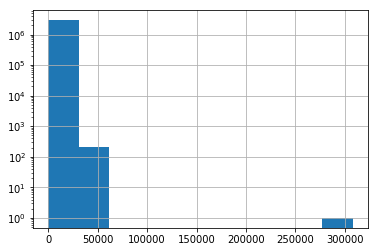

In [54]:
transactions.item_price.hist(log = True)

In [55]:
transactions.item_price.nunique()

19993

In [56]:
transactions.item_price.max()

307980.0

In [57]:
transactions[transactions.item_price == transactions.item_price.max()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,item_category_id,meta_category,city
1163158,2013-12-13,11,12,6066,307980.0,1.0,13,12,2013,75,Программы,Интернет-магазин


In [58]:
items[items.item_id==6066]

,item_name,item_id,item_category_id,meta_category
6066,Radmin 3 - 522 лиц.,6066,75,Программы


In [59]:
# check any price for "6066" item
transactions[transactions.item_id == 6066]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,item_category_id,meta_category,city
1163158,2013-12-13,11,12,6066,307980.0,1.0,13,12,2013,75,Программы,Интернет-магазин


In [60]:
transactions[transactions.item_price>50000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,item_category_id,meta_category,city
885138,2013-09-17,8,12,11365,59200.0,1.0,17,9,2013,9,Доставка товара,Интернет-магазин
1163158,2013-12-13,11,12,6066,307980.0,1.0,13,12,2013,75,Программы,Интернет-магазин
1488135,2014-03-20,14,25,13199,50999.0,1.0,20,3,2014,69,Подарки,Москва


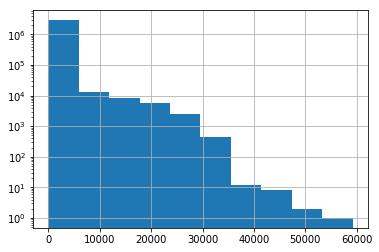

In [61]:
transactions[transactions.item_price < 60000].item_price.hist(log = True)

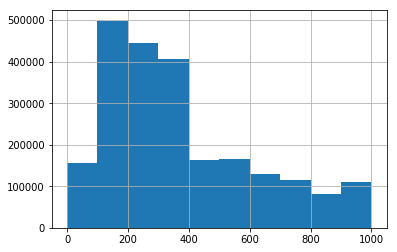

In [62]:
transactions[transactions.item_price < 1000].item_price.hist()

In [63]:
transactions.item_price.value_counts()

299.000000     291352
399.000000     242603
149.000000     218432
199.000000     184044
349.000000     101461
599.000000      95673
999.000000      82784
799.000000      77882
249.000000      77685
699.000000      76493
499.000000      73078
899.000000      57156
1199.000000     55448
1999.000000     49672
99.000000       48955
2599.000000     47857
1499.000000     47196
449.000000      43205
549.000000      39080
5.000000        29702
2999.000000     28929
1299.000000     22381
169.000000      20848
1699.000000     18924
1099.000000     17645
749.000000      17351
1799.000000     17292
2499.000000     16713
1399.000000     15694
1599.000000     14293
                ...  
321.166667          1
599.520000          1
6298.000000         1
1012.782500         1
1176.600000         1
1175.462500         1
1169.025000         1
326.666667          1
226.150000          1
346.666667          1
2094.238095         1
852.198889          1
1252.150000         1
169.280000          1
6399.50000

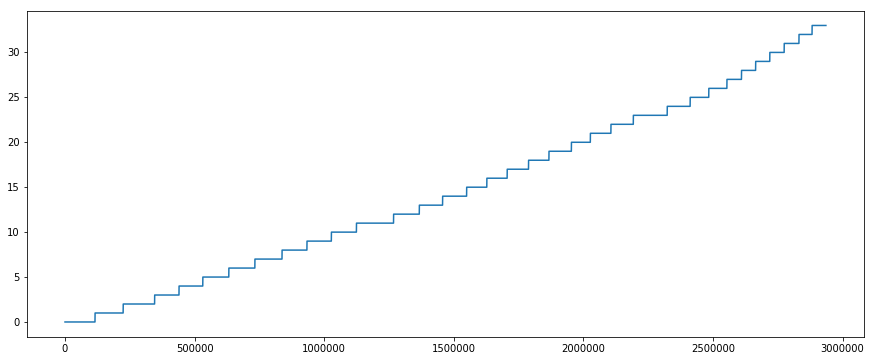

In [64]:
transactions.date_block_num.plot(figsize=(15,6))

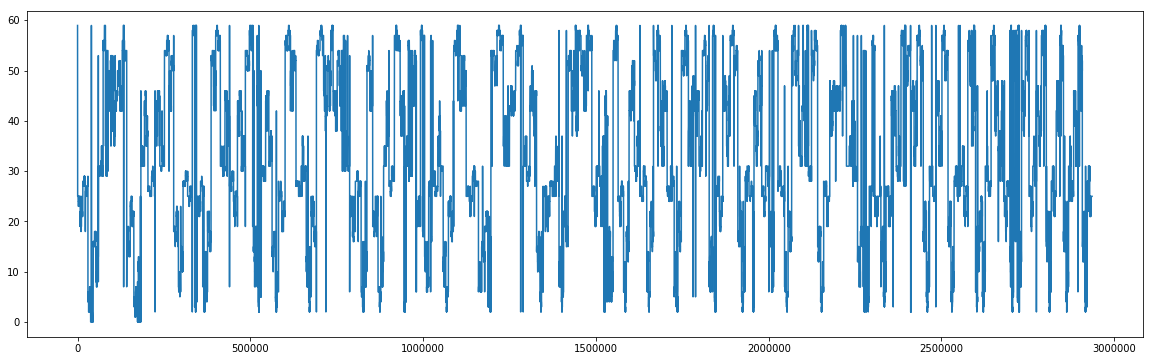

In [65]:
transactions.shop_id.plot(figsize=(20,6))

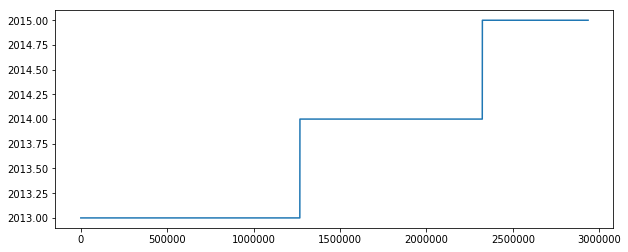

In [66]:
transactions.year.plot(figsize=(10,4))

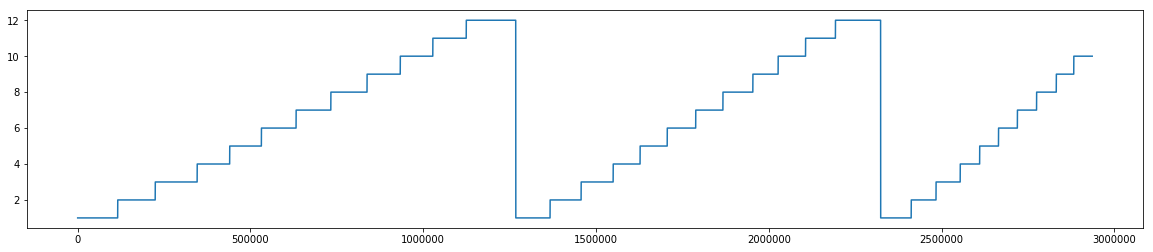

In [67]:
transactions.month.plot(figsize=(20,4))

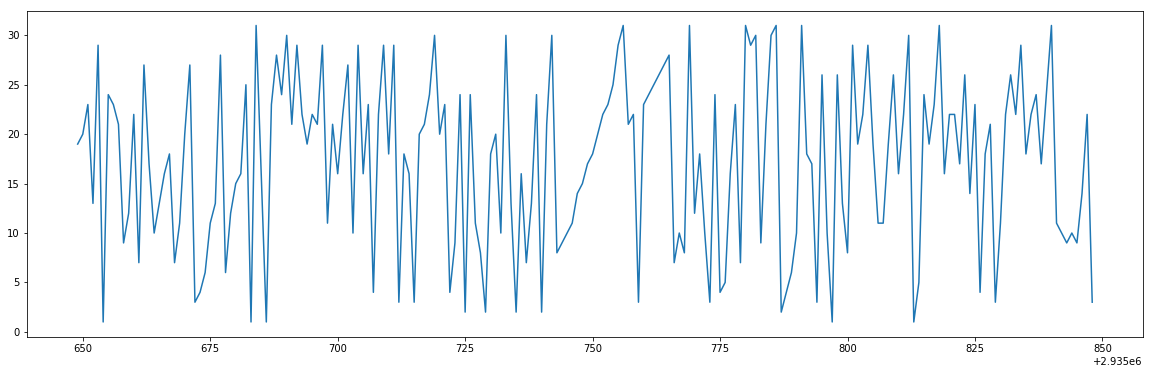

In [68]:
transactions.day[-200:].plot(figsize=(20,6))

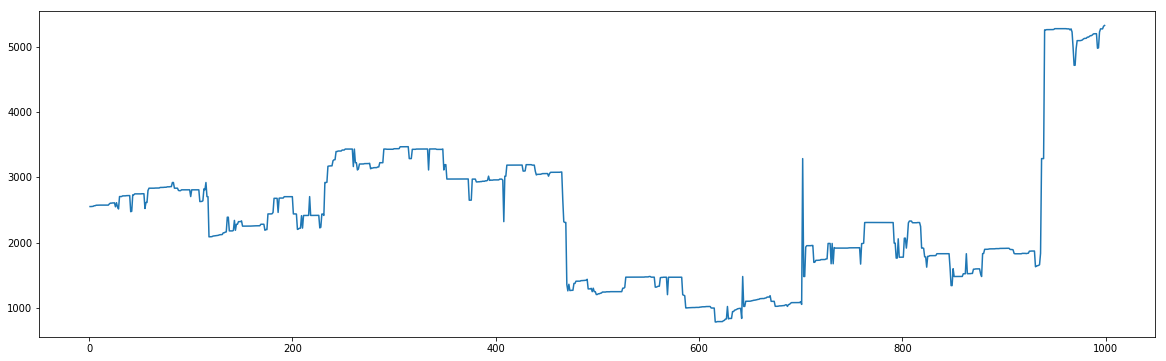

In [69]:
transactions.item_id[1:1000].plot(figsize=(20,6))

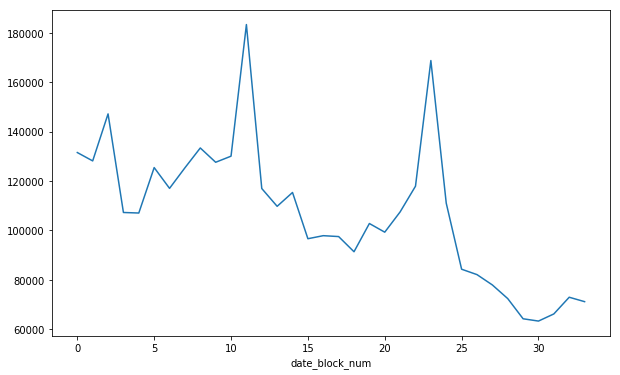

In [70]:
transactions.groupby("date_block_num").sum()["item_cnt_day"].plot(figsize=(10,6))

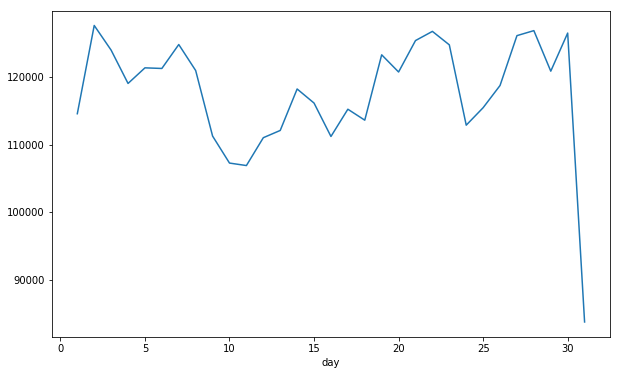

In [71]:
transactions.groupby("day").sum()["item_cnt_day"].plot(figsize=(10,6))

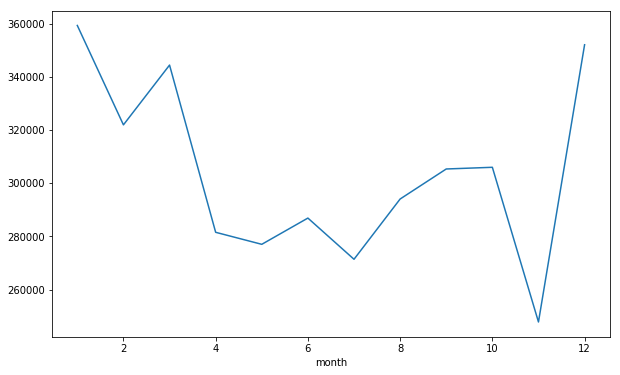

In [72]:
transactions.groupby("month").sum()["item_cnt_day"].plot(figsize=(10,6))

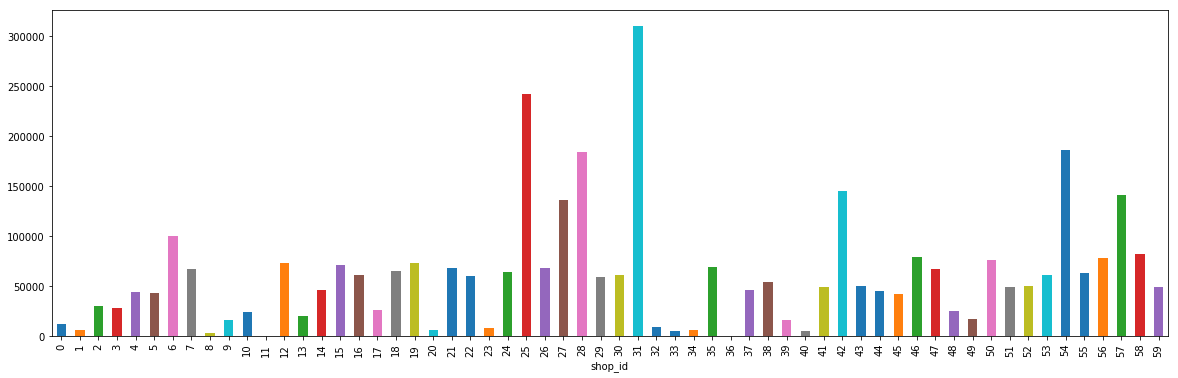

In [73]:
transactions.groupby("shop_id").sum()["item_cnt_day"].plot.bar(figsize=(20,6))

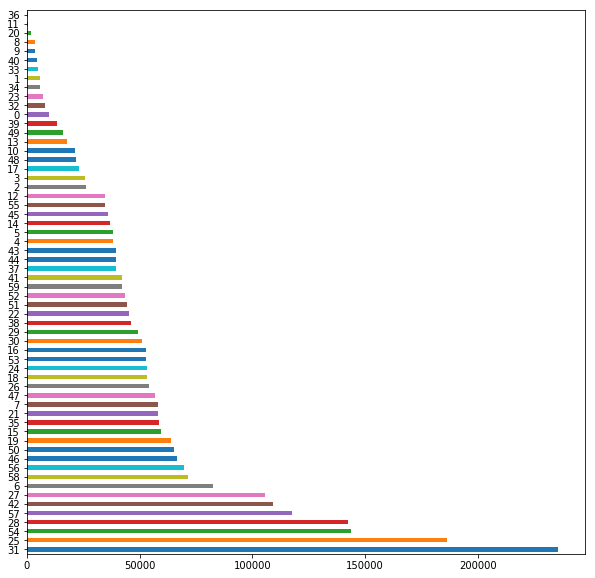

In [74]:
transactions['shop_id'].value_counts().plot.barh(figsize=(10,10))

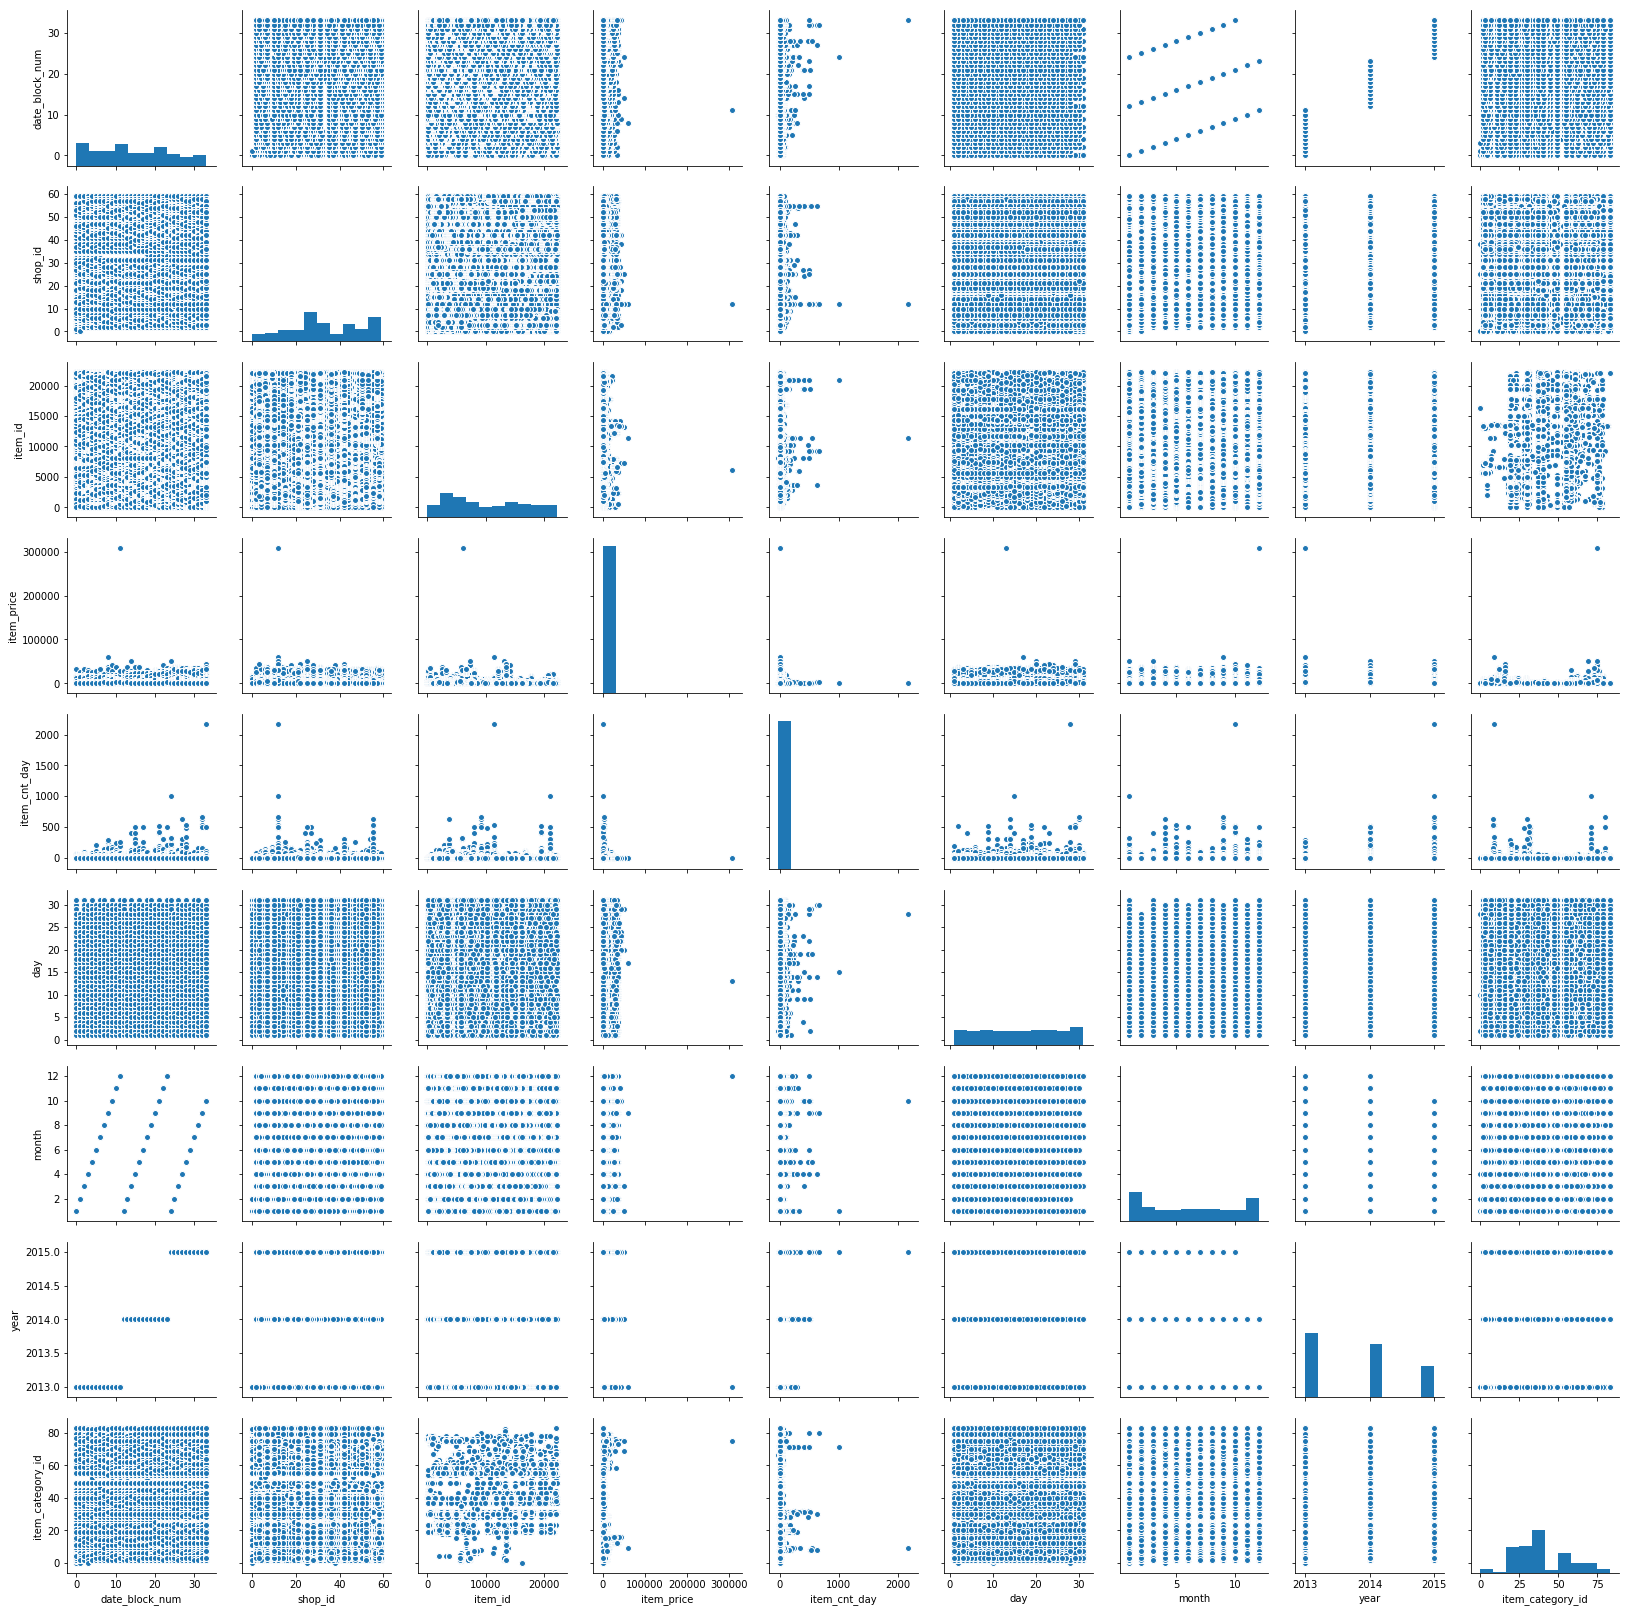

In [75]:
sns.pairplot(transactions)

In [76]:
transactions.groupby(["shop_id","date_block_num"]).count()

date  item_id  item_price  item_cnt_day   day  month  \
shop_id date_block_num                                                         
0       0               4793     4793        4793          4793  4793   4793   
        1               5064     5064        5064          5064  5064   5064   
1       0               2694     2694        2694          2694  2694   2694   
        1               2984     2984        2984          2984  2984   2984   
2       0               1071     1071        1071          1071  1071   1071   
        1                454      454         454           454   454    454   
        2                681      681         681           681   681    681   
        3                556      556         556           556   556    556   
        4                531      531         531           531   531    531   
        5                750      750         750           750   750    750   
        6                768      768         768           768   768    768   
        7                792      792         792           792   792    792   
        8                735      735         735           735   735    735   
        9                634      634         634           634   634    634   
        10               654      654         654           654   654    654   
        11              1163     1163        1163          1163  1163   1163   
        12               830      830         830           830   830    830   
        13               782      782         782           782   782    782   
        14               830      830         830           830   830    830   
        15               718      718         718           718   718    718   
        16               713      713         713           713   713    713   
        17               798      798         798           798   798    798   
        18               691      691         691           691   691    691   
        19               788      788         788           788   788    788   
        20               709      709         709           709   709    709   
        21               783      783         783           783   783    783   
        22               857      857         857           857   857    857   
        23              1525     1525        1525          1525  1525   1525   
        24               871      871         871           871   871    871   
        25               766      766         766           766   766    766   
...                      ...      ...         ...           ...   ...    ...   
59      4               1194     1194        1194          1194  1194   1194   
        5               1465     1465        1465          1465  1465   1465   
        6               1599     1599        1599          1599  1599   1599   
        7               1830     1830        1830          1830  1830   1830   
        8               1580     1580        1580          1580  1580   1580   
        9               1461     1461        1461          1461  1461   1461   
        10              1543     1543        1543          1543  1543   1543   
        11              2043     2043        2043          2043  2043   2043   
        12              1392     1392        1392          1392  1392   1392   
        13              1252     1252        1252          1252  1252   1252   
        14              1275     1275        1275          1275  1275   1275   
        15              1050     1050        1050          1050  1050   1050   
        16              1049     1049        1049          1049  1049   1049   
        17              1013     1013        1013          1013  1013   1013   
        18               974      974         974           974   974    974   
        19              1127     1127        1127          1127  1127   1127   
        20               941      941         941           941   941    941   
        21              

## 4.2. Exam shops and their histories  

In [77]:
shop_history=pd.DataFrame()
shop_history["shop_id"]=np.arange(60)
shop_history["Start"]=transactions.groupby("shop_id")["date_block_num"].min()
shop_history["Stop"]=transactions.groupby("shop_id")["date_block_num"].max()
shop_history.merge(shops, how="left")

,shop_id,Start,Stop,shop_name,city
0,0,0,1,"!Якутск Орджоникидзе, 56 фран",!Якутск
1,1,0,1,"!Якутск ТЦ ""Центральный"" фран",!Якутск
2,2,0,33,"Адыгея ТЦ ""Мега""",Адыгея
3,3,0,33,"Балашиха ТРК ""Октябрь-Киномир""",Балашиха
4,4,0,33,"Волжский ТЦ ""Волга Молл""",Волжский
5,5,1,33,"Вологда ТРЦ ""Мармелад""",Вологда
6,6,0,33,"Воронеж (Плехановская, 13)",Воронеж
7,7,0,33,"Воронеж ТРЦ ""Максимир""",Воронеж
8,8,0,3,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж
9,9,9,33,Выездная Торговля,Выездная


! shop clons: 0 - 57 1 - 58 10 - 11 39 - 40

Check if merge them:

In [78]:
test.groupby("shop_id").count()

,ID,item_id
shop_id,,
2,5100,5100
3,5100,5100
4,5100,5100
5,5100,5100
6,5100,5100
7,5100,5100
10,5100,5100
12,5100,5100
14,5100,5100


## 4.3.  EDA and Data Leakage insights:

- there are some anomal transactions with price more then 100 000 and with cnt more than 1 000

- shops N9 and N20 look like aggregation of some sales-event

- shops NN 0 and 57, 1 and 58, 10 and 11, 39 and 40 look to be clones

- shop cities "Якутск" and "!Якутск" are the same

## 4.4. Cleaning Data after EDA and Data Leakage

In [79]:
# cleanup picks seemed to be anomalies

transactions = transactions[transactions.item_price<100000]
transactions = transactions[transactions.item_cnt_day<=1000]

In [80]:
# cleanup not regular-shop sales

transactions = transactions[transactions.shop_id != 9]
transactions = transactions[transactions.shop_id != 20]

In [81]:
# merge transactions of clone-shops

transactions.loc[transactions.shop_id == 0,  ['shop_id']] = 57
transactions.loc[transactions.shop_id == 1,  ['shop_id']] = 58
transactions.loc[transactions.shop_id == 11, ['shop_id']] = 10
transactions.loc[transactions.shop_id == 40, ['shop_id']] = 39

In [82]:
shops.loc[shops.city == '!Якутск', ['city']] = 'Якутск'

# 5. Advanced Features 
## 5.1 Mean Encodings

Add mean encoding features :

- cnt - count in month, 
- avcnt - average count in month, 
- price - average price in month

for:
- pair item-shop
- item
- shop
- category
- meta_category
- shop city

### Create a grid shops-items-month

In [83]:
# For every month we create a grid from all shops/items combinations from that month
index_cols = ['shop_id', 'item_id', 'date_block_num']

grid = [] 
for block_num in transactions['date_block_num'].unique():
    cur_shops = transactions.loc[transactions['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = transactions.loc[transactions['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)

In [84]:
grid.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [85]:
test_grid = test[['shop_id','item_id']]
test_grid['date_block_num'] = 34

In [86]:
test_grid.head()

,shop_id,item_id,date_block_num
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [87]:
grid = grid.append(test_grid, ignore_index=True)

In [88]:
grid.shape

(10997557, 3)

In [89]:
# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

grid_with_category = pd.merge(grid, 
                              item_category_mapping, 
                              how='left', 
                              on='item_id')

grid_with_category = pd.merge(grid, 
                              items, 
                              how='left', 
                              on='item_id').drop('item_name',axis=1)

grid_with_category = pd.merge(grid_with_category, 
                              shops, 
                              how='left', 
                              on='shop_id').drop('shop_name',axis=1)

In [90]:
grid_with_category.shape

(10997557, 6)

In [91]:
grid_with_category.head()

,shop_id,item_id,date_block_num,item_category_id,meta_category,city
0,59,22154,0,37,Кино,Ярославль
1,59,2552,0,58,Музыка,Ярославль
2,59,2554,0,58,Музыка,Ярославль
3,59,2555,0,56,Музыка,Ярославль
4,59,2564,0,59,Музыка,Ярославль


In [92]:
transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,item_category_id,meta_category,city
0,2013-01-02,0,59,22154,999.00,1.0,2,1,2013,37,Кино,Ярославль
1,2013-01-03,0,25,2552,899.00,1.0,3,1,2013,58,Музыка,Москва
2,2013-01-05,0,25,2552,899.00,-1.0,5,1,2013,58,Музыка,Москва
3,2013-01-06,0,25,2554,1709.05,1.0,6,1,2013,58,Музыка,Москва
4,2013-01-15,0,25,2555,1099.00,1.0,15,1,2013,56,Музыка,Москва


### Add mean encoding features via count in month: 

In [93]:
# Groupby data to get shop-item-month aggregates
gb = transactions.groupby(index_cols,as_index=False).agg(
    {'item_cnt_day':{'cnt_month':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
shop_item_cnt_month = pd.merge(grid_with_category, 
                               gb, 
                               how='left', 
                               on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = transactions.groupby(['shop_id', 'date_block_num'],as_index=False).agg(
    {'item_cnt_day':{'shop_cnt_month':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
shop_item_cnt_month = pd.merge(shop_item_cnt_month, 
                               gb, 
                               how='left', 
                               on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = transactions.groupby(['item_id', 'date_block_num'],as_index=False).agg(
    {'item_cnt_day':{'item_cnt_month':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
shop_item_cnt_month = pd.merge(shop_item_cnt_month, 
                               gb, 
                               how='left', 
                               on=['item_id', 'date_block_num']).fillna(0)

# Same as above but with category-month aggregates
gb = transactions.groupby(['meta_category', 'date_block_num'],as_index=False).agg(
    {'item_cnt_day':{'metacategory_cnt_month':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
shop_item_cnt_month = pd.merge(shop_item_cnt_month, 
                               gb, 
                               how='left', 
                               on=['meta_category', 'date_block_num']).fillna(0)

# Same as above but with city-month aggregates
gb = transactions.groupby(['city', 'date_block_num'],as_index=False).agg(
    {'item_cnt_day':{'city_cnt_month':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
shop_item_cnt_month = pd.merge(shop_item_cnt_month, 
                               gb, 
                               how='left', 
                               on=['city', 'date_block_num']).fillna(0)

# Same as above but with category-month aggregates
gb = transactions.groupby(['item_category_id', 'date_block_num'],as_index=False).agg(
    {'item_cnt_day':{'category_cnt_month':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
shop_item_cnt_month = pd.merge(shop_item_cnt_month, 
                               gb, 
                               how='left', 
                               on=['item_category_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
shop_item_cnt_month = downcast_dtypes(shop_item_cnt_month)
del gb 
gc.collect();

/Users/elena/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [94]:
shop_item_cnt_month.head()

,shop_id,item_id,date_block_num,item_category_id,meta_category,city,cnt_month,shop_cnt_month,item_cnt_month,metacategory_cnt_month,city_cnt_month,category_cnt_month
0,59,22154,0,37,Кино,Ярославль,1.0,2017.0,18.0,43002.0,2017.0,6094.0
1,59,2552,0,58,Музыка,Ярославль,0.0,2017.0,0.0,15407.0,2017.0,287.0
2,59,2554,0,58,Музыка,Ярославль,0.0,2017.0,1.0,15407.0,2017.0,287.0
3,59,2555,0,56,Музыка,Ярославль,0.0,2017.0,2.0,15407.0,2017.0,268.0
4,59,2564,0,59,Музыка,Ярославль,0.0,2017.0,5.0,15407.0,2017.0,701.0


In [95]:
shop_item_cnt_month.shape

(10997557, 12)

### Add mean encoding features via average count in month: 

In [96]:
# Groupby data to get shop-item-month aggregates
gb = transactions.groupby(index_cols,as_index=False).agg(
    {'item_cnt_day':{'avcnt_month':'mean'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
shop_item_avcnt_month = pd.merge(grid_with_category, 
                               gb, 
                               how='left', 
                               on=index_cols).fillna(gb['avcnt_month'].median())

# Same as above but with shop-month aggregates
gb = transactions.groupby(['shop_id', 'date_block_num'],as_index=False).agg(
    {'item_cnt_day':{'shop_avcnt_month':'mean'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
shop_item_avcnt_month = pd.merge(shop_item_avcnt_month, 
                               gb, 
                               how='left', 
                               on=['shop_id', 'date_block_num']).fillna(gb['shop_avcnt_month'].median())

# Same as above but with item-month aggregates
gb = transactions.groupby(['item_id', 'date_block_num'],as_index=False).agg(
    {'item_cnt_day':{'item_avcnt_month':'mean'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
shop_item_avcnt_month = pd.merge(shop_item_avcnt_month, 
                               gb, 
                               how='left', 
                               on=['item_id', 'date_block_num']).fillna(gb['item_avcnt_month'].median())

# Same as above but with category-month aggregates
gb = transactions.groupby(['meta_category', 'date_block_num'],as_index=False).agg(
    {'item_cnt_day':{'metacategory_avcnt_month':'mean'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
shop_item_avcnt_month = pd.merge(shop_item_avcnt_month, 
                               gb, 
                               how='left', 
                               on=['meta_category', 'date_block_num']).fillna(gb['metacategory_avcnt_month'].median())

# Same as above but with city-month aggregates
gb = transactions.groupby(['city', 'date_block_num'],as_index=False).agg(
    {'item_cnt_day':{'city_avcnt_month':'mean'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
shop_item_avcnt_month = pd.merge(shop_item_avcnt_month, 
                               gb, 
                               how='left', 
                               on=['city', 'date_block_num']).fillna(gb['city_avcnt_month'].median())

# Same as above but with category-month aggregates
gb = transactions.groupby(['item_category_id', 'date_block_num'],as_index=False).agg(
    {'item_cnt_day':{'category_avcnt_month':'mean'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
shop_item_avcnt_month = pd.merge(shop_item_avcnt_month, 
                               gb, 
                               how='left', 
                               on=['item_category_id', 'date_block_num']).fillna(gb['category_avcnt_month'].median())

# Downcast dtypes from 64 to 32 bit to save memory
shop_item_avcnt_month = downcast_dtypes(shop_item_avcnt_month)
del gb 
gc.collect();

/Users/elena/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [97]:
shop_item_avcnt_month.head()

,shop_id,item_id,date_block_num,item_category_id,meta_category,city,avcnt_month,shop_avcnt_month,item_avcnt_month,metacategory_avcnt_month,city_avcnt_month,category_avcnt_month
0,59,22154,0,37,Кино,Ярославль,1.0,1.092041,1.0,1.120077,1.092041,1.053414
1,59,2552,0,58,Музыка,Ярославль,1.0,1.092041,0.0,1.020466,1.092041,0.969595
2,59,2554,0,58,Музыка,Ярославль,1.0,1.092041,1.0,1.020466,1.092041,0.969595
3,59,2555,0,56,Музыка,Ярославль,1.0,1.092041,1.0,1.020466,1.092041,1.007519
4,59,2564,0,59,Музыка,Ярославль,1.0,1.092041,1.0,1.020466,1.092041,0.990113


In [98]:
shop_item_avcnt_month.shape

(10997557, 12)

### Add mean encoding features via average price in month: 

In [99]:
# Groupby data to get shop-item-month aggregates
gb = transactions.groupby(index_cols,as_index=False).agg(
    {'item_price':{'price_month':'mean'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
shop_item_price_month = pd.merge(grid_with_category, 
                                 gb, 
                                 how='left', 
                                 on=index_cols).fillna(gb['price_month'].median())

# Same as above but with shop-month aggregates
gb = transactions.groupby(['shop_id', 'date_block_num'],as_index=False).agg(
    {'item_price':{'shop_price_month':'mean'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
shop_item_price_month = pd.merge(shop_item_price_month, 
                                 gb, 
                                 how='left', 
                                 on=['shop_id', 'date_block_num']).fillna(gb['shop_price_month'].median())

# Same as above but with item-month aggregates
gb = transactions.groupby(['item_id', 'date_block_num'],as_index=False).agg(
    {'item_price':{'item_price_month':'mean'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
shop_item_price_month = pd.merge(shop_item_price_month, 
                                 gb, 
                                 how='left', 
                                 on=['item_id', 'date_block_num']).fillna(gb['item_price_month'].median())

# Same as above but with category-month aggregates
gb = transactions.groupby(['meta_category', 'date_block_num'],as_index=False).agg(
    {'item_price':{'metacategory_price_month':'mean'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
shop_item_price_month = pd.merge(shop_item_price_month, 
                                 gb, 
                                 how='left', 
                                 on=['meta_category', 'date_block_num']).fillna(gb['metacategory_price_month'].median())

# Same as above but with city-month aggregates
gb = transactions.groupby(['city', 'date_block_num'],as_index=False).agg(
    {'item_price':{'city_price_month':'mean'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
shop_item_price_month = pd.merge(shop_item_price_month, 
                               gb, 
                               how='left', 
                               on=['city', 'date_block_num']).fillna(gb['city_price_month'].median())

# Same as above but with category-month aggregates
gb = transactions.groupby(['item_category_id', 'date_block_num'],as_index=False).agg(
    {'item_price':{'category_price_month':'mean'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
shop_item_price_month = pd.merge(shop_item_price_month, 
                                 gb, 
                                 how='left', 
                                 on=['item_category_id', 'date_block_num']).fillna(gb['category_price_month'].median())

# Downcast dtypes from 64 to 32 bit to save memory
shop_item_price_month = downcast_dtypes(shop_item_price_month)
del gb 
gc.collect();

/Users/elena/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [100]:
shop_item_price_month.head()

,shop_id,item_id,date_block_num,item_category_id,meta_category,city,price_month,shop_price_month,item_price_month,metacategory_price_month,city_price_month,category_price_month
0,59,22154,0,37,Кино,Ярославль,999.0,820.174561,999.000000,345.765961,820.174561,465.036011
1,59,2552,0,58,Музыка,Ярославль,399.0,820.174561,899.000000,322.940338,820.174561,1401.858154
2,59,2554,0,58,Музыка,Ярославль,399.0,820.174561,1709.050049,322.940338,820.174561,1401.858154
3,59,2555,0,56,Музыка,Ярославль,399.0,820.174561,1098.849976,322.940338,820.174561,867.447021
4,59,2564,0,59,Музыка,Ярославль,399.0,820.174561,327.600006,322.940338,820.174561,443.330017


In [101]:
shop_item_price_month.shape

(10997557, 12)

### Pickle transactions with mean encoding features 

In [102]:
with open('work_data/shop_item_avcnt_month.pickle', 'wb') as f:
    pickle.dump(shop_item_avcnt_month, f)
with open('work_data/shop_item_cnt_month.pickle', 'wb') as f:
    pickle.dump(shop_item_cnt_month, f)
with open('work_data/shop_item_price_month.pickle', 'wb') as f:
    pickle.dump(shop_item_price_month, f)

## 5.2. Additional advanced features 

Create lag features with different lag periods (1,2,3,4,5,12 months) for all mean encoding features.

In [103]:
def add_lags(df, index_cols=['shop_id','item_id','date_block_num','meta_category','item_category_id','city']):
    
    # List of columns that we will use to create lags
    cols_to_rename = list(df.columns.difference(index_cols)) 
    df_lags = df.copy()

    shift_range = [1, 2, 3, 4, 5, 12]

    for month_shift in shift_range:
        train_shift = df[index_cols + cols_to_rename].copy()

        train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift

        foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
        train_shift = train_shift.rename(columns=foo)

        df_lags = pd.merge(df_lags, train_shift, on=index_cols, how='left').fillna(0)
    
    del train_shift

    # List of all lagged features
    fit_cols = [col for col in df_lags.columns if col[-1] in [str(item) for item in shift_range]] 

    df_lags = downcast_dtypes(df_lags)
    gc.collect();    
    
    return df_lags

In [104]:
shop_item_avcnt_month_lags = add_lags(shop_item_avcnt_month)

In [105]:
shop_item_cnt_month_lags = add_lags(shop_item_cnt_month)

In [106]:
shop_item_price_month_lags = add_lags(shop_item_price_month)

In [107]:
# do not use the first 12 months

shop_item_avcnt_month_lags = shop_item_avcnt_month_lags[shop_item_avcnt_month_lags['date_block_num'] >= 12] 
shop_item_cnt_month_lags = shop_item_cnt_month_lags[shop_item_cnt_month_lags['date_block_num'] >= 12] 
shop_item_price_month_lags = shop_item_price_month_lags[shop_item_price_month_lags['date_block_num'] >= 12] 

In [108]:
shop_item_price_month_lags.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_category_id',
       'meta_category', 'city', 'price_month', 'shop_price_month',
       'item_price_month', 'metacategory_price_month', 'city_price_month',
       'category_price_month', 'category_price_month_lag_1',
       'city_price_month_lag_1', 'item_price_month_lag_1',
       'metacategory_price_month_lag_1', 'price_month_lag_1',
       'shop_price_month_lag_1', 'category_price_month_lag_2',
       'city_price_month_lag_2', 'item_price_month_lag_2',
       'metacategory_price_month_lag_2', 'price_month_lag_2',
       'shop_price_month_lag_2', 'category_price_month_lag_3',
       'city_price_month_lag_3', 'item_price_month_lag_3',
       'metacategory_price_month_lag_3', 'price_month_lag_3',
       'shop_price_month_lag_3', 'category_price_month_lag_4',
       'city_price_month_lag_4', 'item_price_month_lag_4',
       'metacategory_price_month_lag_4', 'price_month_lag_4',
       'shop_price_month_lag_4', 'category_price_month_la

### Pickle transactions with lags mean encoding features 

In [109]:
with open('work_data/shop_item_avcnt_month_lags.pickle', 'wb') as f:
    pickle.dump(shop_item_avcnt_month_lags, f)
with open('work_data/shop_item_cnt_month_lags.pickle', 'wb') as f:
    pickle.dump(shop_item_cnt_month_lags, f)
with open('work_data/shop_item_price_month_lags.pickle', 'wb') as f:
    pickle.dump(shop_item_price_month_lags, f)

In [110]:
all_mean_enc_month_lags = pd.merge(shop_item_cnt_month_lags,
                                    shop_item_price_month_lags,
                                    how='left', 
                                    on=['item_id', 'shop_id', 'item_category_id', 'meta_category', 'city', 'date_block_num'])
all_mean_enc_month_lags = pd.merge(all_mean_enc_month_lags,
                                    shop_item_avcnt_month_lags,
                                    how='left', 
                                    on=['item_id', 'shop_id', 'item_category_id', 'meta_category', 'city', 'date_block_num'])

In [111]:
all_mean_enc_month_lags['month']=all_mean_enc_month_lags.date_block_num%12

In [112]:
all_mean_enc_month_lags['city'] = all_mean_enc_month_lags['city'].astype('category').cat.codes
all_mean_enc_month_lags['meta_category'] = all_mean_enc_month_lags['meta_category'].astype('category').cat.codes

In [113]:
all_mean_enc_month_lags.head()

,shop_id,item_id,date_block_num,item_category_id,meta_category,city,cnt_month,shop_cnt_month,item_cnt_month,metacategory_cnt_month,...,item_avcnt_month_lag_5,metacategory_avcnt_month_lag_5,shop_avcnt_month_lag_5,avcnt_month_lag_12,category_avcnt_month_lag_12,city_avcnt_month_lag_12,item_avcnt_month_lag_12,metacategory_avcnt_month_lag_12,shop_avcnt_month_lag_12,month
0,54,10297,12,37,11,25,4.0,8198.0,23.0,32257.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
1,54,10296,12,38,11,25,3.0,8198.0,17.0,32257.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
2,54,10298,12,40,11,25,14.0,8198.0,182.0,32257.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
3,54,10300,12,37,11,25,3.0,8198.0,26.0,32257.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
4,54,10284,12,57,13,25,1.0,8198.0,3.0,12043.0,...,1.0,1.017079,1.231158,0.0,0.0,0.0,0.0,0.0,0.0,0


# 6. Prepair train and valid data sets for simple Light GBM  and Linear Model 

In [114]:
all_mean_enc_month_lags['city'] = all_mean_enc_month_lags['city'].astype('category').cat.codes
all_mean_enc_month_lags['meta_category'] = all_mean_enc_month_lags['meta_category'].astype('category').cat.codes

In [115]:
dates = all_mean_enc_month_lags['date_block_num']
valid_block = 33
test_block = 34

non_lag_features = ['shop_id', 'item_id', 'item_category_id', 'meta_category', 'city', 'date_block_num', 'month']
shift_range = [1,2,3,4,5,12]

# List of all lagged features
lags_cols = [col for col in all_mean_enc_month_lags.columns if col[-1] in [str(item) for item in shift_range]] 
fit_cols = lags_cols + ['shop_id', 'item_id', 'date_block_num', 'month']

# We will drop these at fitting stage
to_drop_cols = list(set(list(all_mean_enc_month_lags.columns)) - (set(fit_cols))) 

In [116]:
fit_cols

['category_cnt_month_lag_1',
 'city_cnt_month_lag_1',
 'cnt_month_lag_1',
 'item_cnt_month_lag_1',
 'metacategory_cnt_month_lag_1',
 'shop_cnt_month_lag_1',
 'category_cnt_month_lag_2',
 'city_cnt_month_lag_2',
 'cnt_month_lag_2',
 'item_cnt_month_lag_2',
 'metacategory_cnt_month_lag_2',
 'shop_cnt_month_lag_2',
 'category_cnt_month_lag_3',
 'city_cnt_month_lag_3',
 'cnt_month_lag_3',
 'item_cnt_month_lag_3',
 'metacategory_cnt_month_lag_3',
 'shop_cnt_month_lag_3',
 'category_cnt_month_lag_4',
 'city_cnt_month_lag_4',
 'cnt_month_lag_4',
 'item_cnt_month_lag_4',
 'metacategory_cnt_month_lag_4',
 'shop_cnt_month_lag_4',
 'category_cnt_month_lag_5',
 'city_cnt_month_lag_5',
 'cnt_month_lag_5',
 'item_cnt_month_lag_5',
 'metacategory_cnt_month_lag_5',
 'shop_cnt_month_lag_5',
 'category_cnt_month_lag_12',
 'city_cnt_month_lag_12',
 'cnt_month_lag_12',
 'item_cnt_month_lag_12',
 'metacategory_cnt_month_lag_12',
 'shop_cnt_month_lag_12',
 'category_price_month_lag_1',
 'city_price_month_la

In [117]:
to_drop_cols

['avcnt_month',
 'shop_avcnt_month',
 'item_cnt_month',
 'city_price_month',
 'category_avcnt_month',
 'meta_category',
 'metacategory_cnt_month',
 'price_month',
 'shop_price_month',
 'item_price_month',
 'category_cnt_month',
 'item_avcnt_month',
 'category_price_month',
 'item_category_id',
 'city_cnt_month',
 'shop_cnt_month',
 'cnt_month',
 'metacategory_avcnt_month',
 'city_avcnt_month',
 'metacategory_price_month',
 'city']

In [118]:
dates_train = dates[dates <  valid_block]
dates_valid  = dates[dates == valid_block]

X_train = all_mean_enc_month_lags.loc[dates <  valid_block].drop(to_drop_cols, axis=1)
X_valid = all_mean_enc_month_lags.loc[dates == valid_block].drop(to_drop_cols, axis=1)
X       = all_mean_enc_month_lags.loc[dates < test_block].drop(to_drop_cols, axis=1)

y_train = all_mean_enc_month_lags.loc[dates <  valid_block, 'cnt_month'].values
y_valid = all_mean_enc_month_lags.loc[dates == valid_block, 'cnt_month'].values
y       = all_mean_enc_month_lags.loc[dates <  test_block, 'cnt_month'].values

X_test  = all_mean_enc_month_lags.loc[dates == test_block].drop(to_drop_cols, axis=1)

In [119]:
X_train.head()

,shop_id,item_id,date_block_num,category_cnt_month_lag_1,city_cnt_month_lag_1,cnt_month_lag_1,item_cnt_month_lag_1,metacategory_cnt_month_lag_1,shop_cnt_month_lag_1,category_cnt_month_lag_2,...,item_avcnt_month_lag_5,metacategory_avcnt_month_lag_5,shop_avcnt_month_lag_5,avcnt_month_lag_12,category_avcnt_month_lag_12,city_avcnt_month_lag_12,item_avcnt_month_lag_12,metacategory_avcnt_month_lag_12,shop_avcnt_month_lag_12,month
0,54,10297,12,9959.0,10055.0,3.0,42.0,42496.0,10055.0,7420.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
1,54,10296,12,2052.0,10055.0,0.0,24.0,42496.0,10055.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
2,54,10298,12,28598.0,10055.0,21.0,369.0,42496.0,10055.0,25433.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
3,54,10300,12,9959.0,10055.0,1.0,54.0,42496.0,10055.0,7420.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
4,54,10284,12,1425.0,10055.0,0.0,4.0,18997.0,10055.0,1054.0,...,1.0,1.017079,1.231158,0.0,0.0,0.0,0.0,0.0,0.0,0


# 7. Simple LightGBM

In [120]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model_lgb = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model_lgb.predict(X_valid)

print('Test mean_squared_error for LightGBM is %f' % mean_squared_error(y_valid, pred_lgb))
print('Test r2_score for LightGBM is %f' % r2_score(y_valid, pred_lgb))

Test mean_squared_error for LightGBM is 3.446432
Test r2_score for LightGBM is 0.502762


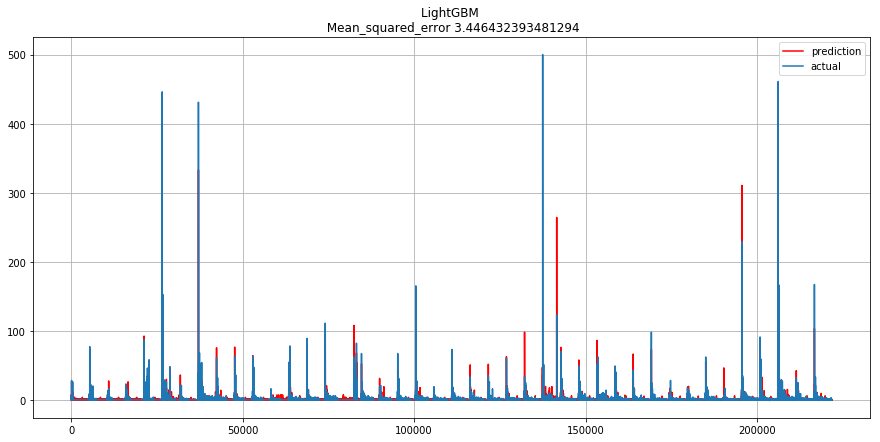

In [121]:
plt.figure(figsize=(15, 7))
plt.plot(pred_lgb, "r", label="prediction")
plt.plot(y_valid, label="actual")
plt.legend(loc="best")
plt.title("LightGBM \n Mean_squared_error {}".format(mean_squared_error(y_valid, pred_lgb)))
plt.grid(True);

### Train and predict for test 

In [122]:
model_lgb = lgb.train(lgb_params, lgb.Dataset(X, label=y), 100)
pred_lgb = model_lgb.predict(X_test)

In [123]:
with open('models/simple_lgb.pickle', 'wb') as f:
    pickle.dump(model_lgb, f)

In [124]:
y_pr=X_test[['shop_id','item_id']].copy()
y_pr['item_cnt_month'] = pred_lgb

test_data_for_submit = pd.merge(test, y_pr, how='left', on=['shop_id','item_id']).fillna(0)
test_data_for_submit.item_cnt_month = np.clip(test_data_for_submit.item_cnt_month, 0, 20)

test_data_for_submit[['ID','item_cnt_month']].to_csv('sub_simple_LGB23.csv', index=False)

### Look for importance features

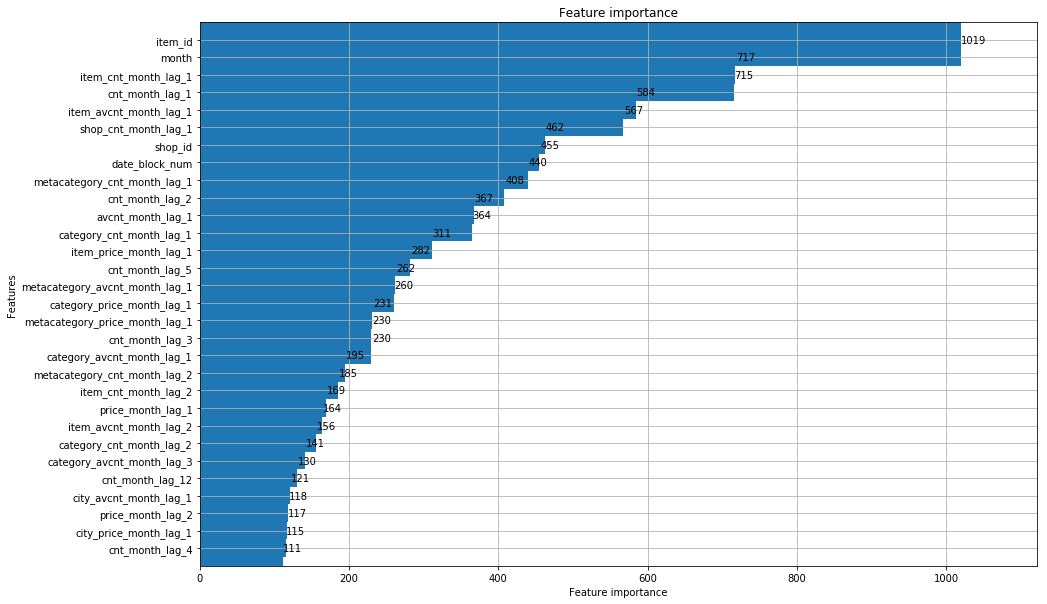

In [125]:
lgb.plot_importance(model_lgb,height=3,max_num_features=30,figsize=(15,10))

# 8. Simple Linear Regression

In [126]:
model_lr = LinearRegression()
model_lr.fit(X_train.values, y_train)
pred_lr = model_lr.predict(X_valid.values)

print('Test mean_squared_error for linreg is %f' % mean_squared_error(y_valid, pred_lr))
print('Test r2_score for linreg is %f' % r2_score(y_valid, pred_lr))

/Users/elena/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Test mean_squared_error for linreg is 3.118701
Test r2_score for linreg is 0.550046


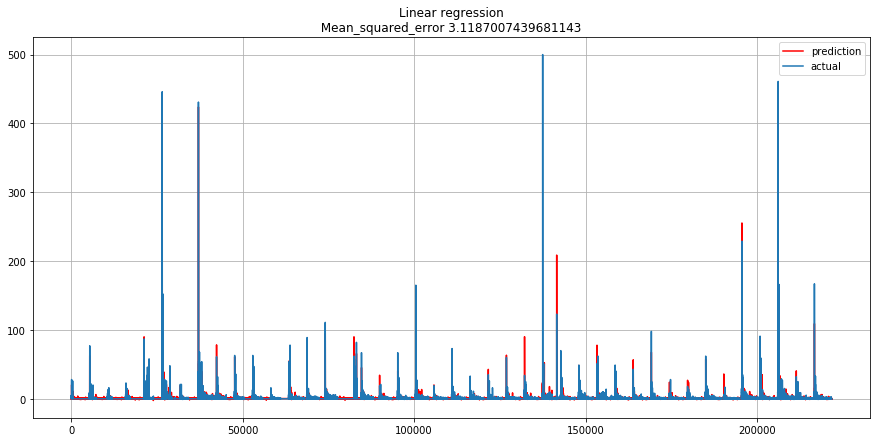

In [127]:
plt.figure(figsize=(15, 7))
plt.plot(pred_lr, "r", label="prediction")
plt.plot(y_valid, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean_squared_error {} ".format(mean_squared_error(y_valid, pred_lr)))
plt.grid(True);

### Train and predict for test 

In [128]:
model_lr.fit(X.values, y)
pred_lr = model_lr.predict(X_test.values)

In [129]:
with open('models/simple_lr.pickle', 'wb') as f:
    pickle.dump(model_lr, f)

In [130]:
y_pr=X_test[['shop_id','item_id']].copy()
y_pr['item_cnt_month'] = pred_lr

test_data_for_submit = pd.merge(test, y_pr, how='left', on=['shop_id','item_id']).fillna(0)
test_data_for_submit.item_cnt_month = np.clip(test_data_for_submit.item_cnt_month, 0, 20)

test_data_for_submit[['ID','item_cnt_month']].to_csv('sub_simple_LR23.csv', index=False)

### Look for importance features

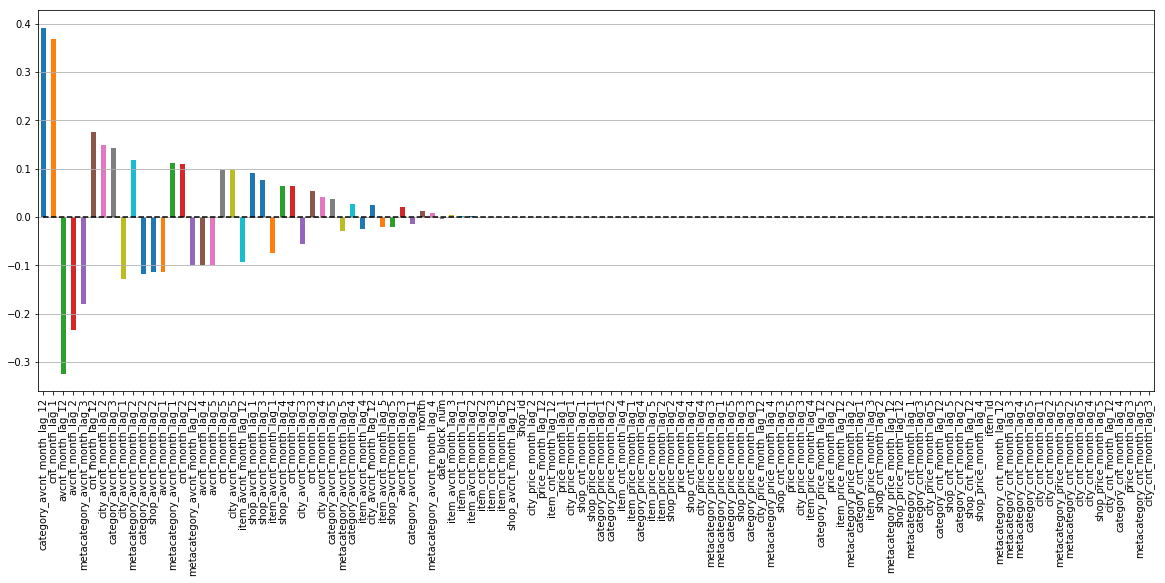

In [131]:
coefs = pd.DataFrame(model_lr.coef_, X_test.columns)
coefs.columns = ["coef"]
coefs["abs"] = coefs.coef.apply(np.abs)
coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
plt.figure(figsize=(20, 7))
coefs.coef.plot(kind='bar')
plt.grid(True, axis='y')
plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')

# 9. Cross Validation

## 9.1. CV for LightGBM

In [132]:
print('Size train set: {}'.format(X_train.shape))
errors_lgb = np.zeros(21)

lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }


# loop from the first 2 folds to the total number of folds    
for i in range(13, 34):
    print('Validation on the month N',i)

    X_trainfold = all_mean_enc_month_lags.loc[dates <  i].drop(to_drop_cols, axis=1)
    X_validfold = all_mean_enc_month_lags.loc[dates == i].drop(to_drop_cols, axis=1)

    y_trainfold = all_mean_enc_month_lags.loc[dates <  i, 'cnt_month'].values
    y_validfold = all_mean_enc_month_lags.loc[dates == i, 'cnt_month'].values

    model = lgb.train(lgb_params, lgb.Dataset(X_trainfold, label=y_trainfold), 100)
    pred_lgb_cv = model.predict(X_validfold)

    errors_lgb[i-13] = mean_squared_error(y_validfold, pred_lgb_cv)
    print("Error: ", errors_lgb[i-13])

print()
print(errors_lgb.mean())

Size train set: (6088084, 112)
Validation on the month N 13
Error:  6.085219181470244
Validation on the month N 14
Error:  6.119031180087887
Validation on the month N 15
Error:  7.405197443537857
Validation on the month N 16
Error:  3.453776880215574
Validation on the month N 17
Error:  3.697398770921372
Validation on the month N 18
Error:  2.429218219303193
Validation on the month N 19
Error:  2.668262844956294
Validation on the month N 20
Error:  9.85321370443966
Validation on the month N 21
Error:  9.097757097552021
Validation on the month N 22
Error:  10.715081017929592
Validation on the month N 23
Error:  13.044115610482764
Validation on the month N 24
Error:  11.112521157052354
Validation on the month N 25
Error:  4.03226012871027
Validation on the month N 26
Error:  3.5546462209832366
Validation on the month N 27
Error:  18.490324892238533
Validation on the month N 28
Error:  9.479719473568057
Validation on the month N 29
Error:  2.0789985903760004
Validation on the month N 30
E

## 9.2. CV for Linear model

In [133]:
print('Size train set: {}'.format(X_train.shape))
errors_lr_cv = np.zeros(21)
model_lr = LinearRegression()

# loop from the first 2 folds to the total number of folds    
for i in range(13, 34):
    print('Validation on the month N',i)

    X_trainfold = all_mean_enc_month_lags.loc[dates <  i].drop(to_drop_cols, axis=1)
    X_validfold = all_mean_enc_month_lags.loc[dates == i].drop(to_drop_cols, axis=1)

    y_trainfold = all_mean_enc_month_lags.loc[dates <  i, 'cnt_month'].values
    y_validfold = all_mean_enc_month_lags.loc[dates == i, 'cnt_month'].values

    model_lr.fit(X_trainfold.values, y_trainfold)
    pred_lr_cv = model_lr.predict(X_validfold.values)

    errors_lr_cv[i-13] = mean_squared_error(y_validfold, pred_lr_cv)
    print("Error: ", errors_lr_cv[i-13])

print()
print(errors_lr_cv.mean())

Size train set: (6088084, 112)
Validation on the month N 13
Error:  2.3955751076763017
Validation on the month N 14
Error:  3.9564651595524625
Validation on the month N 15
Error:  5.97457286556121
Validation on the month N 16
Error:  3.3400948532284174
Validation on the month N 17
Error:  2.777646400379441
Validation on the month N 18
Error:  1.4665853214777764
Validation on the month N 19
Error:  1.6672161846848288
Validation on the month N 20
Error:  9.097888661625708
Validation on the month N 21
Error:  7.5141518560262535
Validation on the month N 22
Error:  9.465920696004865
Validation on the month N 23
Error:  7.7872434172436
Validation on the month N 24
Error:  11.645390749430772
Validation on the month N 25
Error:  8.61495236129573
Validation on the month N 26
Error:  5.083251556587196
Validation on the month N 27
Error:  18.278365977676525
Validation on the month N 28
Error:  10.934371863716
Validation on the month N 29
Error:  1.9037177476115417
Validation on the month N 30
Er

# 10. Metrics optimization and Hyperparameter tuning
## 10.1. CV_grid_optimization for LightGBM

In [136]:
best_num_boost_round = 10
best_learning_rate = 0.2
best_num_leaves = 20
best_min_data_in_leaf = 20
best_fraction = 0.75

best_error = 9.0
    
for min_data_in_leaf in [20, 100]:
    for num_leaves in [20, 70]:
        for learning_rate in [0.20, 0.15, 0.10]: 
            for num_boost_round in [50, 100]: 

                lgb_params = {
                                'bagging_fraction': 0.75,
                                'bagging_freq': 1,      
                                'feature_fraction': 0.75,
                                'learning_rate': learning_rate,
                                'min_data_in_leaf': min_data_in_leaf,
                                'num_leaves': num_leaves,
                                'metric': 'rmse'
                              }

                errors_lgb = np.zeros(3)

                for i in range(13, 16):

                    X_trainfold = all_mean_enc_month_lags.loc[dates <  i].drop(to_drop_cols, axis=1)
                    X_validfold = all_mean_enc_month_lags.loc[dates == i].drop(to_drop_cols, axis=1)

                    y_trainfold = all_mean_enc_month_lags.loc[dates <  i, 'cnt_month'].values
                    y_validfold = all_mean_enc_month_lags.loc[dates == i, 'cnt_month'].values

                    model_lgb = lgb.train(lgb_params, 
                                          lgb.Dataset(X_trainfold, label=y_trainfold), 
                                          num_boost_round=num_boost_round)
                    pred_lgb_cv = model_lgb.predict(X_validfold)

                    errors_lgb[i-13] = mean_squared_error(y_validfold, pred_lgb_cv)

                if best_error > errors_lgb.mean():
                    best_error = errors_lgb.mean()
                    best_num_boost_round = num_boost_round
                    best_learning_rate = learning_rate
                    best_num_leaves = num_leaves
                    best_min_data_in_leaf = min_data_in_leaf

print()
print ("best_error:",best_error) 
print ("best_num_boost_round:",best_num_boost_round) 
print ("best_learning_rate:",best_learning_rate) 
print ("best_num_leaves:",best_num_leaves) 
print ("best_min_data_in_leaf:",best_min_data_in_leaf) 


best_error: 4.453444654126625
best_num_boost_round: 100
best_learning_rate: 0.1
best_num_leaves: 20
best_min_data_in_leaf: 20


In [137]:
lgb_params = {
                'bagging_fraction': best_fraction,
                'bagging_freq': 1,      
                'feature_fraction': best_fraction,
                'learning_rate': best_learning_rate,
                'min_data_in_leaf': best_min_data_in_leaf,
                'num_leaves': best_num_leaves,
                'metric': 'rmse'
              }

In [138]:
model_lgb = lgb.train(lgb_params, 
                      lgb.Dataset(X_train, label=y_train), 
                      num_boost_round=best_num_boost_round)
pred_lgb_valid = model_lgb.predict(X_valid)

In [139]:
model_lgb = lgb.train(lgb_params, 
                      lgb.Dataset(X, label=y), 
                      num_boost_round=best_num_boost_round)
pred_lgb = model_lgb.predict(X_test)

In [140]:
with open('models/best_lgb.pickle', 'wb') as f:
    pickle.dump(model_lgb, f)

In [141]:
y_pr=X_test[['shop_id','item_id']].copy()
y_pr['item_cnt_month'] = pred_lgb

test_data_for_submit = pd.merge(test, y_pr, how='left', on=['shop_id','item_id']).fillna(0)
test_data_for_submit.item_cnt_month = np.clip(test_data_for_submit.item_cnt_month, 0, 20)

test_data_for_submit[['ID','item_cnt_month']].to_csv('sub_best_lgb23.csv', index=False)

## 10.2. CV_grid_optimization for Linear Model

In [143]:
best_error_lasso = 7.0
best_alpha_lasso = 1

for alpha in [1, 0.1, 0.01]:
    errors_lasso_cv = np.zeros(12)
    
    model_lasso = linear_model.Lasso(alpha=alpha, max_iter=1000)

    for i in range(13, 25):
        print('Validation on the month N',i)

        X_trainfold = all_mean_enc_month_lags.loc[dates <  i].drop(to_drop_cols, axis=1)
        X_validfold = all_mean_enc_month_lags.loc[dates == i].drop(to_drop_cols, axis=1)

        y_trainfold = all_mean_enc_month_lags.loc[dates <  i, 'cnt_month'].values
        y_validfold = all_mean_enc_month_lags.loc[dates == i, 'cnt_month'].values

        model_lasso.fit(X_trainfold.values, y_trainfold)
        lasso_pred = model_lasso.predict(X_validfold)

        errors_lasso_cv[i-13] = mean_squared_error(y_validfold, lasso_pred)
        print("Error: ", errors_lasso_cv[i-13])

    print(errors_lasso_cv.mean())    
    if errors_lasso_cv.mean() < best_error_lasso:
        best_error_lasso = errors_lasso_cv.mean()
        best_alpha_lasso = alpha
        
print("best_error_lasso:", best_error_lasso)
print("best_alpha_lasso:", best_alpha_lasso)

Validation on the month N 13
Error:  2.7461842393110327
Validation on the month N 14
Error:  4.181312279781509
Validation on the month N 15
Error:  6.070030634592295
Validation on the month N 16
Error:  2.9348516572029872
Validation on the month N 17
Error:  3.159351767743665
Validation on the month N 18
Error:  1.750642724951672
Validation on the month N 19
Error:  2.092207954387237
Validation on the month N 20
Error:  9.589545701221487
Validation on the month N 21
Error:  8.180762775481746
Validation on the month N 22
Error:  10.712749723792603
Validation on the month N 23
Error:  10.401855960774292
Validation on the month N 24
Error:  9.610957392609185
5.95253773432081
Validation on the month N 13
Error:  2.5265249534926753
Validation on the month N 14
Error:  3.983957214628687
Validation on the month N 15
Error:  5.93035611902593
Validation on the month N 16
Error:  2.8638271155654964
Validation on the month N 17
Error:  2.9511437728383885
Validation on the month N 18
Error:  1.468

/Users/elena/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Error:  2.433093050301612
Validation on the month N 14
Error:  4.028942093249711
Validation on the month N 15
Error:  5.950874553160506
Validation on the month N 16
Error:  2.8680973495128455
Validation on the month N 17
Error:  2.749652314875564
Validation on the month N 18
Error:  1.4630899728317355
Validation on the month N 19
Error:  1.648630038299893
Validation on the month N 20
Error:  9.133335398299897
Validation on the month N 21
Error:  7.52145298903481
Validation on the month N 22
Error:  9.422856615377894
Validation on the month N 23
Error:  7.937084336763358
Validation on the month N 24
Error:  11.196302044438132
5.529450896345497
best_error_lasso: 5.475197947934418
best_alpha_lasso: 0.1


In [144]:
model_lasso = linear_model.Lasso(alpha=best_alpha_lasso, max_iter=1000)

In [145]:
model_lasso.fit(X_train.values, y_train)
lasso_pred_valid = model_lasso.predict(X_valid)

In [146]:
model_lasso.fit(X.values, y)
lasso_pred = model_lasso.predict(X_test)

In [147]:
with open('models/lasso.pickle', 'wb') as f:
    pickle.dump(model_lasso, f)

In [148]:
y_pr=X_test[['shop_id','item_id']].copy()
y_pr['item_cnt_month'] = lasso_pred

test_data_for_submit = pd.merge(test, y_pr, how='left', on=['shop_id','item_id']).fillna(0)
test_data_for_submit.item_cnt_month = np.clip(test_data_for_submit.item_cnt_month, 0, 20)

test_data_for_submit[['ID','item_cnt_month']].to_csv('sub_Lasso23.csv', index=False)

# 11.Ensemble

In [149]:
alphas = np.linspace(0, 1, 100)
errors=[]
scores=[]

for alpha in alphas:
    mix = alpha*lasso_pred_valid + (1-alpha)*pred_lgb_valid
    scores.append(r2_score(y_valid, mix))
    errors.append(mean_squared_error(y_valid, mix))

best_alpha = alphas[np.array(scores).argmax()] 
score_train_simple_mix = np.array(scores).max() 
error_train_simple_mix = errors[np.array(scores).argmax()]

print('Best alpha: %f; Corresponding err on train: %f; Corresponding score on train: %f' % 
      (best_alpha, error_train_simple_mix,  score_train_simple_mix))

Best alpha: 0.888889; Corresponding err on train: 3.122067; Corresponding score on train: 0.549560


In [150]:
mix = best_alpha*lasso_pred + (1-best_alpha)*pred_lgb

y_pr=X_test[['shop_id','item_id']].copy()
y_pr['item_cnt_month'] = mix

test_data_for_submit = pd.merge(test, y_pr, how='left', on=['shop_id','item_id']).fillna(0)
test_data_for_submit.item_cnt_month = np.clip(test_data_for_submit.item_cnt_month, 0, 20)

test_data_for_submit[['ID','item_cnt_month']].to_csv('sub_LR_GBM_ans23.csv', index=False)